In [3]:
# Step 1: Import Libraries
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
import os
from tensorflow.keras import backend as K
import shutil

# Clear session to avoid any cached model conflicts
K.clear_session()

# Load Data from CSV
data = pd.read_csv('topography.csv')  # Replace with your CSV file path
X_primary = data[['Sa', 'angle']].values
y_support = data[['sigma_s_rho', 'Sq']].values  # Adjust to include all support parameters
y_process = data[['cpower1', 'cspeed1', 'cpower2', 'cspeed2']].values

# Remove NaN values
mask = ~np.isnan(X_primary).any(axis=1) & ~np.isnan(y_support).any(axis=1) & ~np.isnan(y_process).any(axis=1)
X_primary = X_primary[mask]
y_support = y_support[mask]
y_process = y_process[mask]

# Split data
X_train_primary, X_test_primary, y_train_support, y_test_support, y_train_process, y_test_process = train_test_split(
    X_primary, y_support, y_process, test_size=0.2, random_state=32)

# Standard scaling
scaler_primary = StandardScaler()
X_train_primary_scaled = scaler_primary.fit_transform(X_train_primary).astype(np.float32)
X_test_primary_scaled = scaler_primary.transform(X_test_primary).astype(np.float32)
y_train_support = y_train_support.astype(np.float32)
y_test_support = y_test_support.astype(np.float32)

# Step 2: Define Supporting Parameters Model with Keras Tuner
def build_supporting_model(hp):
    model = Sequential()
    for i in range(3):
        model.add(Dense(units=hp.Choice('units', [256, 512, 768]), activation='relu'))
        model.add(Dropout(rate=hp.Choice('dropout_rate', [0.2, 0.3, 0.4])))

    model.add(Dense(y_train_support.shape[1]))  # Output layer for supporting parameters
    model.compile(optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']),
                  loss='mse', metrics=['mae'])
    return model

# Delete the tuning directory if it exists
if os.path.exists('supporting_dir'):
    shutil.rmtree('supporting_dir')

# Keras Tuner for Supporting Model
support_tuner = kt.RandomSearch(
    build_supporting_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='supporting_dir',
    project_name='supporting_model_tuning'
)

# Train Supporting Model
support_tuner.search(X_train_primary_scaled, y_train_support, epochs=300, validation_data=(X_test_primary_scaled, y_test_support), batch_size=32)
best_support_model = support_tuner.get_best_models(num_models=1)[0]

# Generate Supporting Parameter Predictions for Training & Testing Sets
y_train_support_pred = best_support_model.predict(X_train_primary_scaled, batch_size=32)
y_test_support_pred = best_support_model.predict(X_test_primary_scaled, batch_size=32)

# Combine primary inputs and predicted supporting parameters
X_train_full = np.hstack((X_train_primary_scaled, y_train_support_pred)).astype(np.float32)
X_test_full = np.hstack((X_test_primary_scaled, y_test_support_pred)).astype(np.float32)

# Step 3: Define Process Parameter Model with MC Dropout Active
def build_individual_process_model(hp):
    inputs = Input(shape=(X_train_full.shape[1],))
    x = inputs
    for i in range(3):
        x = Dense(units=hp.Choice('units', [256, 512, 768]), activation='relu')(x)
        x = Dropout(rate=hp.Choice('dropout_rate', [0.2, 0.3, 0.4]))(x, training=True)  # MC Dropout enabled
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']),
                  loss='mse', metrics=['mae'])
    return model

# Function to generate multiple MC Dropout predictions
def monte_carlo_dropout_prediction(model, X_sample, n_iter=100):
    """Generates multiple predictions using MC Dropout and returns all samples."""
    dropout_preds = []
    for _ in range(n_iter):
        prediction = model(np.expand_dims(X_sample, axis=0), training=True)
        dropout_preds.append(prediction.numpy().flatten()[0])
    return np.array(dropout_preds)  # Return full distribution

# Step 4: Train and Generate Predictions
mc_samples_data = {}  # Store all MC Dropout samples

for idx, param in enumerate(['cpower1', 'cspeed1', 'cpower2', 'cspeed2']):
    y_train_param = y_train_process[:, idx]
    y_test_param = y_test_process[:, idx]

    # Delete tuning directory if it exists
    param_dir = f'{param}_dir'
    if os.path.exists(param_dir):
        shutil.rmtree(param_dir)

    # Train model
    tuner = kt.RandomSearch(
        build_individual_process_model,
        objective='val_loss',
        max_trials=10,
        executions_per_trial=1,
        directory=param_dir,
        project_name=f'{param}_model_tuning'
    )
    tuner.search(X_train_full, y_train_param, epochs=300, validation_data=(X_test_full, y_test_param), batch_size=32)
    best_model = tuner.get_best_models(num_models=1)[0]

    # Generate predictions
    for i, (X_sample, y_actual) in enumerate(zip(X_test_primary_scaled, y_test_process)):
        support_pred = best_support_model.predict(np.expand_dims(X_sample, axis=0), batch_size=42).flatten()
        X_combined = np.hstack((X_sample, support_pred)).astype(np.float32)

        # Get full MC Dropout sample distribution
        mc_samples = monte_carlo_dropout_prediction(best_model, X_combined)
        mc_samples_data[f'{param}_sample_{i}'] = mc_samples.tolist()

# Save All MC Dropout Samples
mc_samples_df = pd.DataFrame(mc_samples_data)
mc_samples_df.to_csv('mc_dropout_samples.csv', index=False)

print("CSV file 'mc_dropout_samples.csv' created with all MC Dropout samples.")


Trial 10 Complete [00h 00m 22s]
val_loss: 90759.140625

Best val_loss So Far: 82749.265625
Total elapsed time: 00h 03m 53s
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1

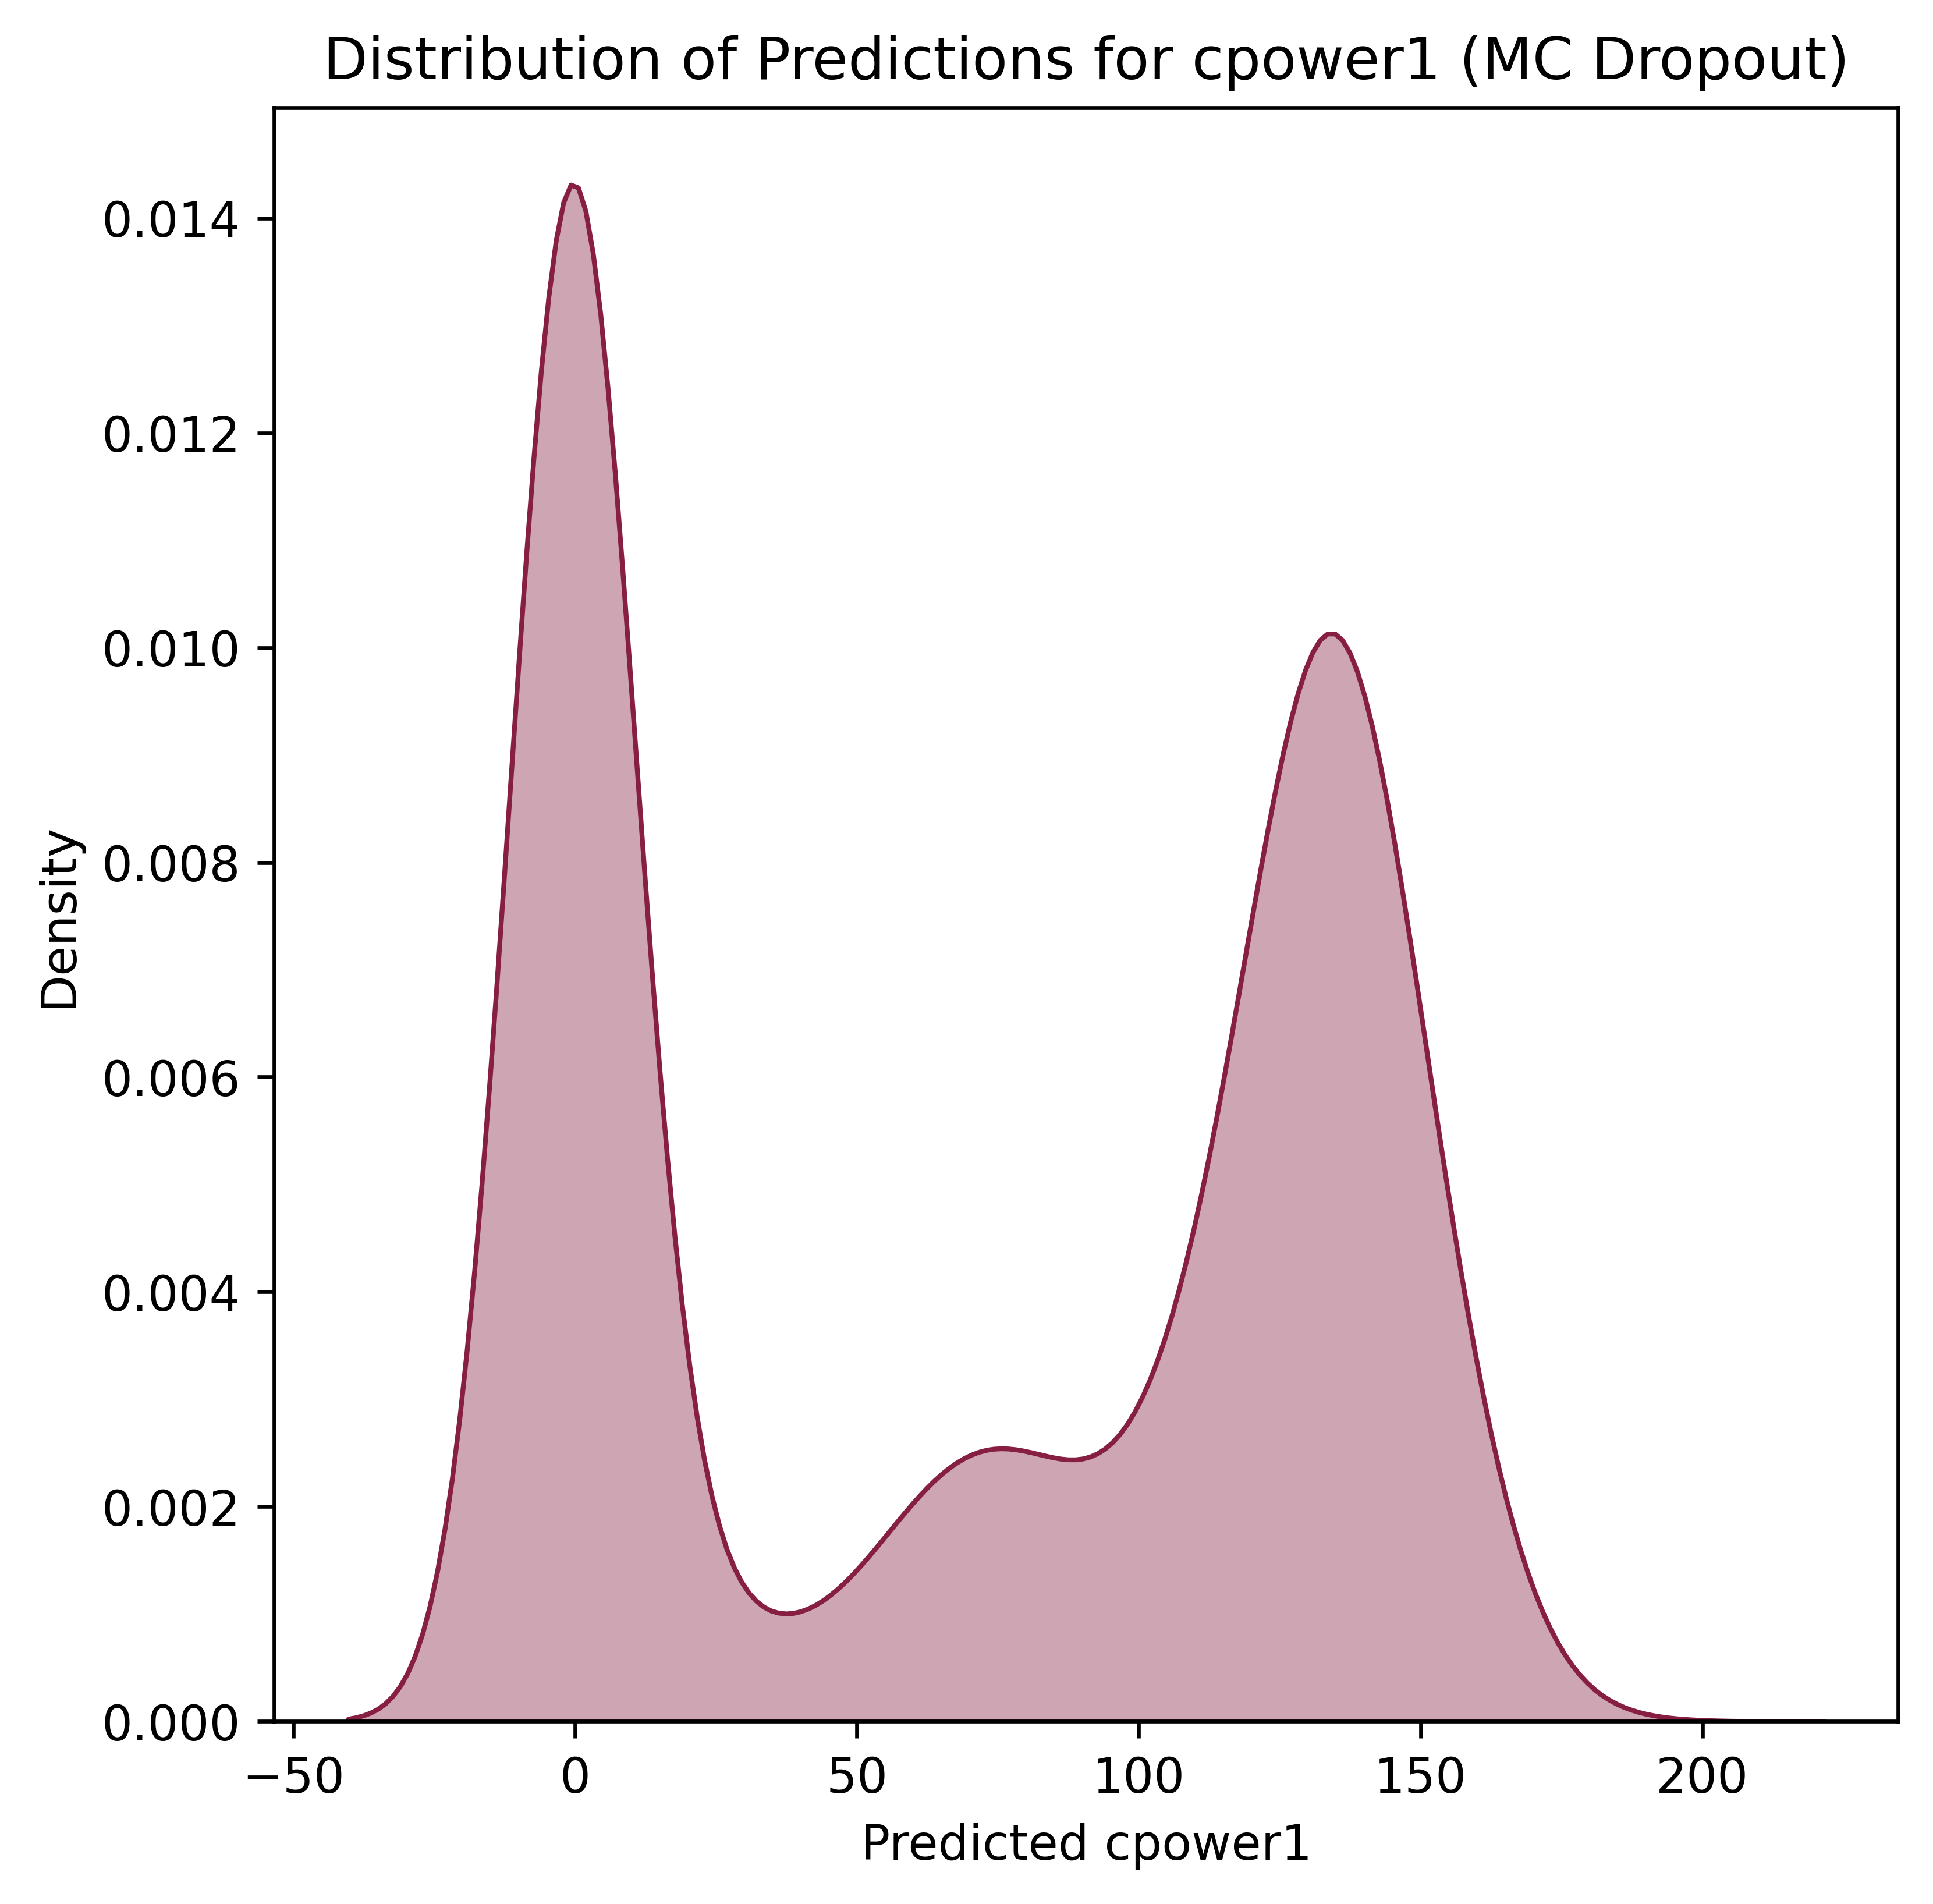

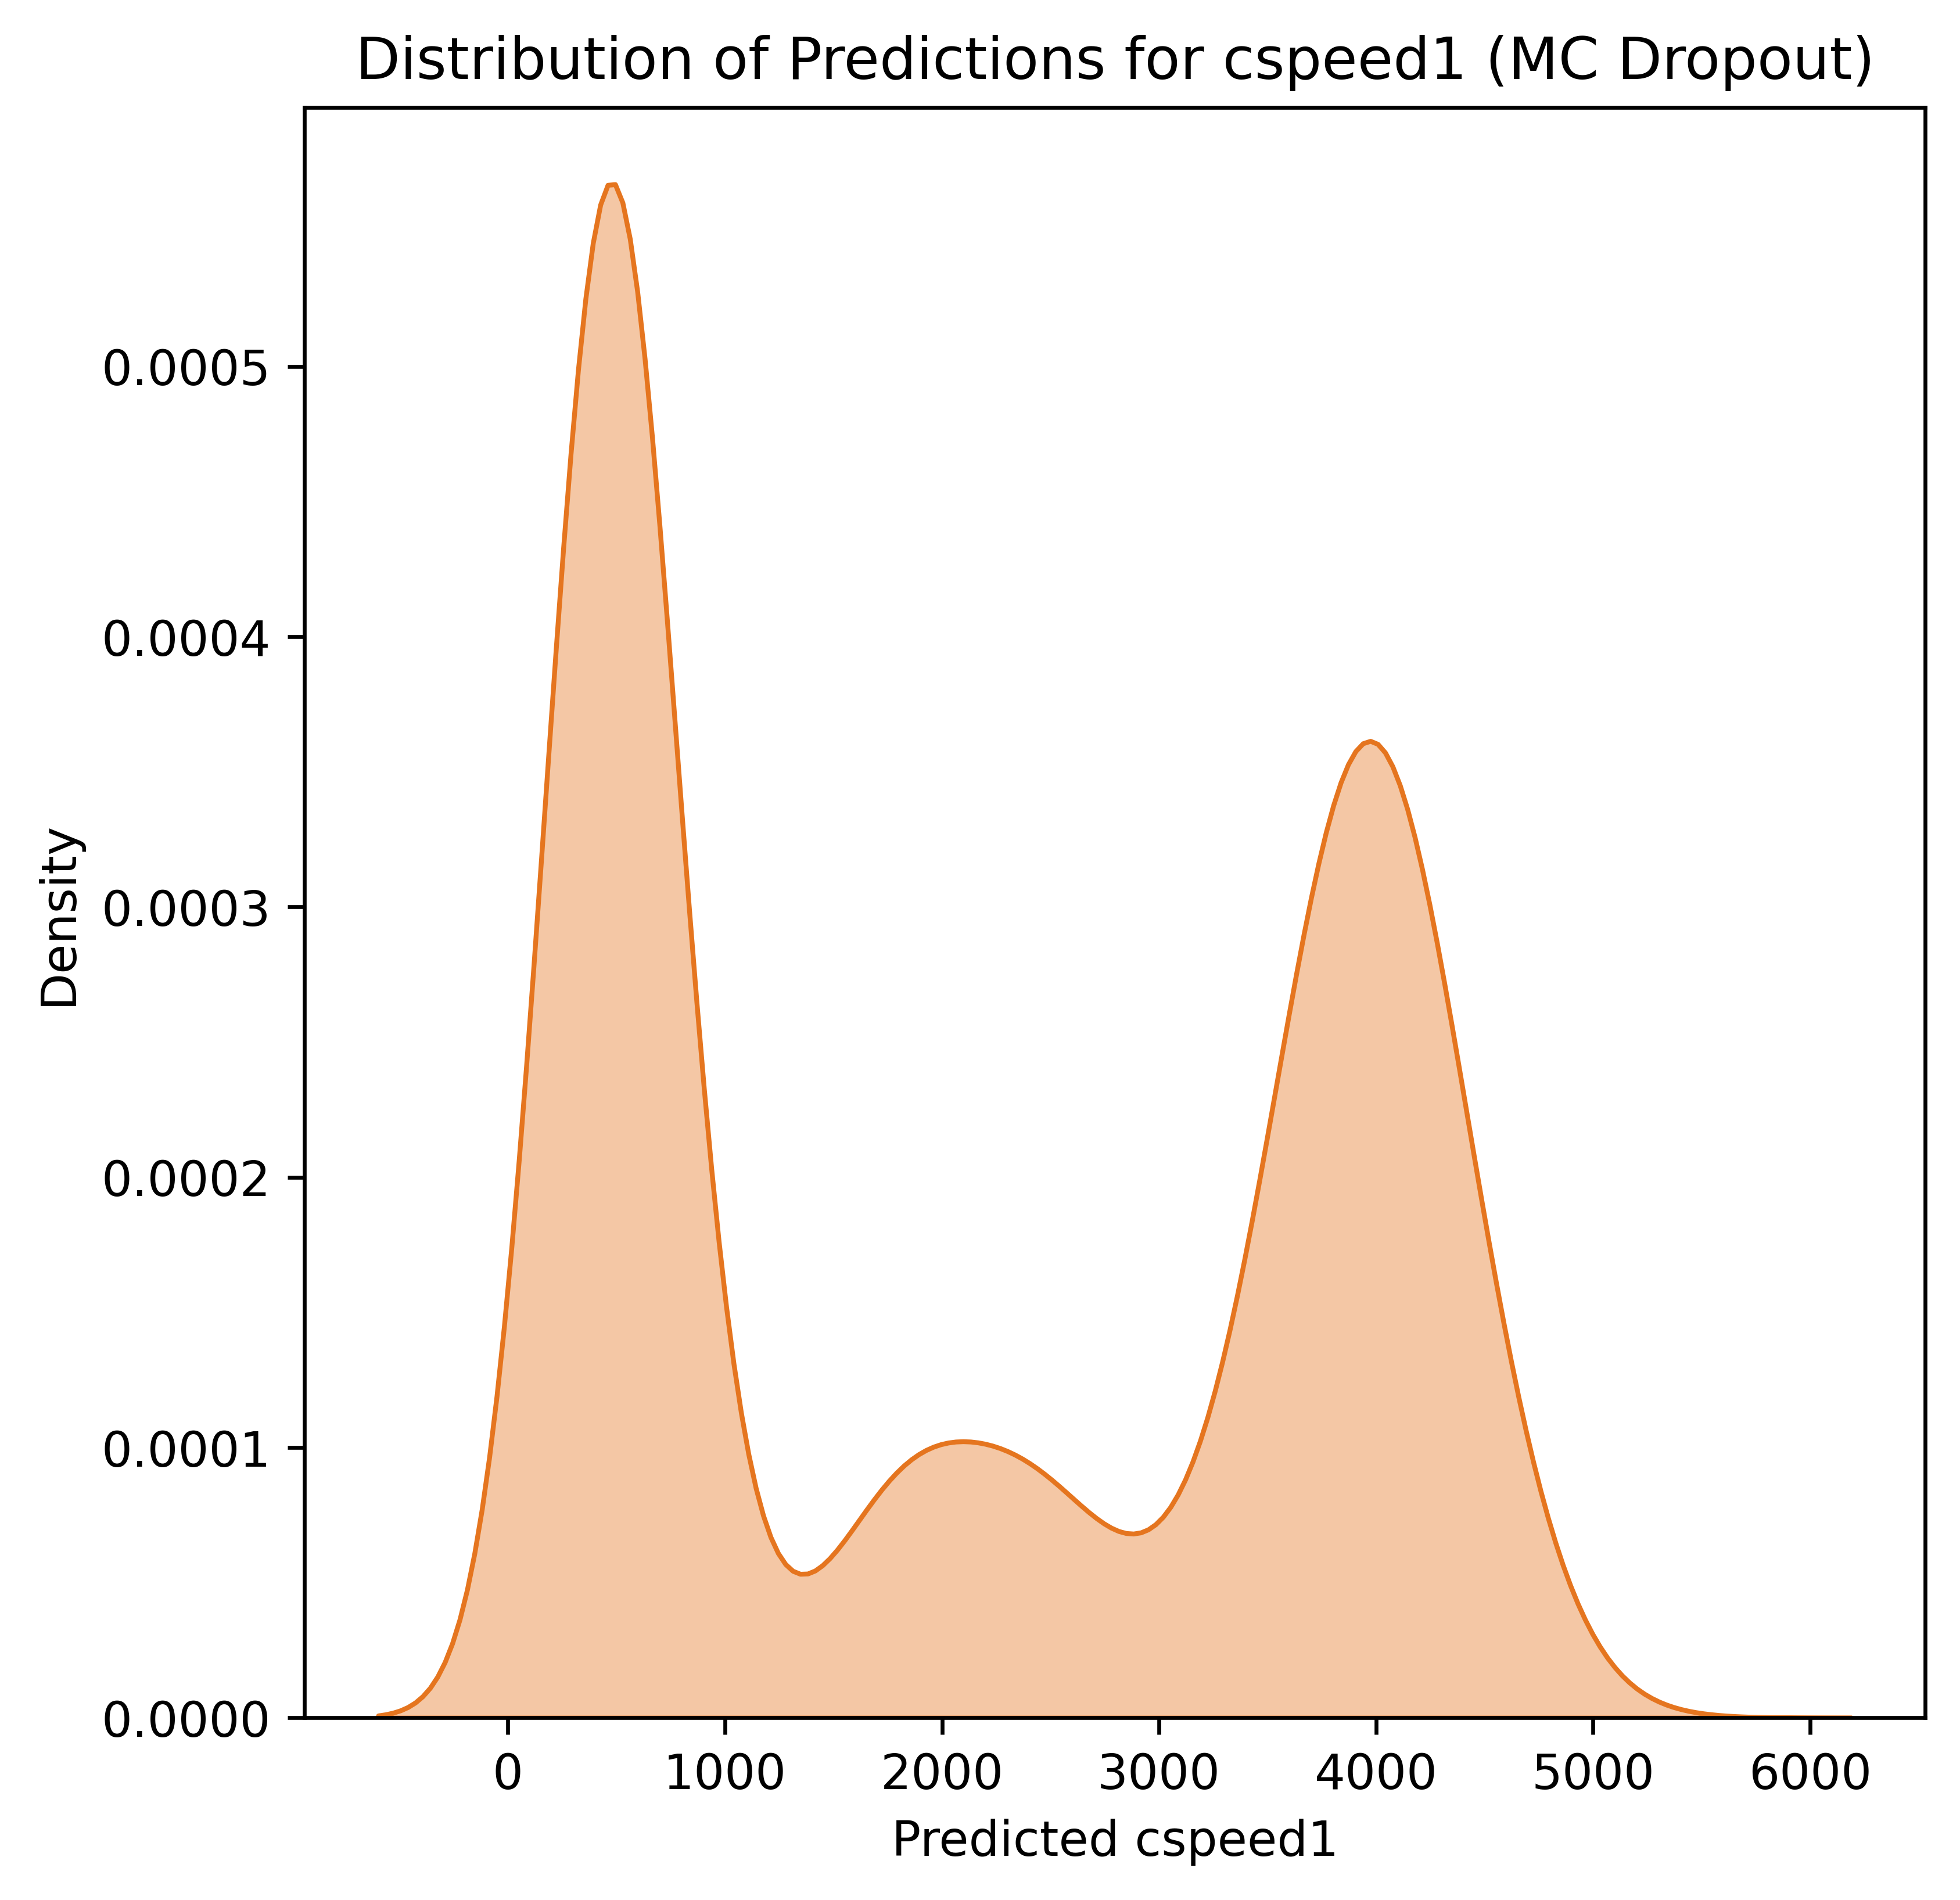

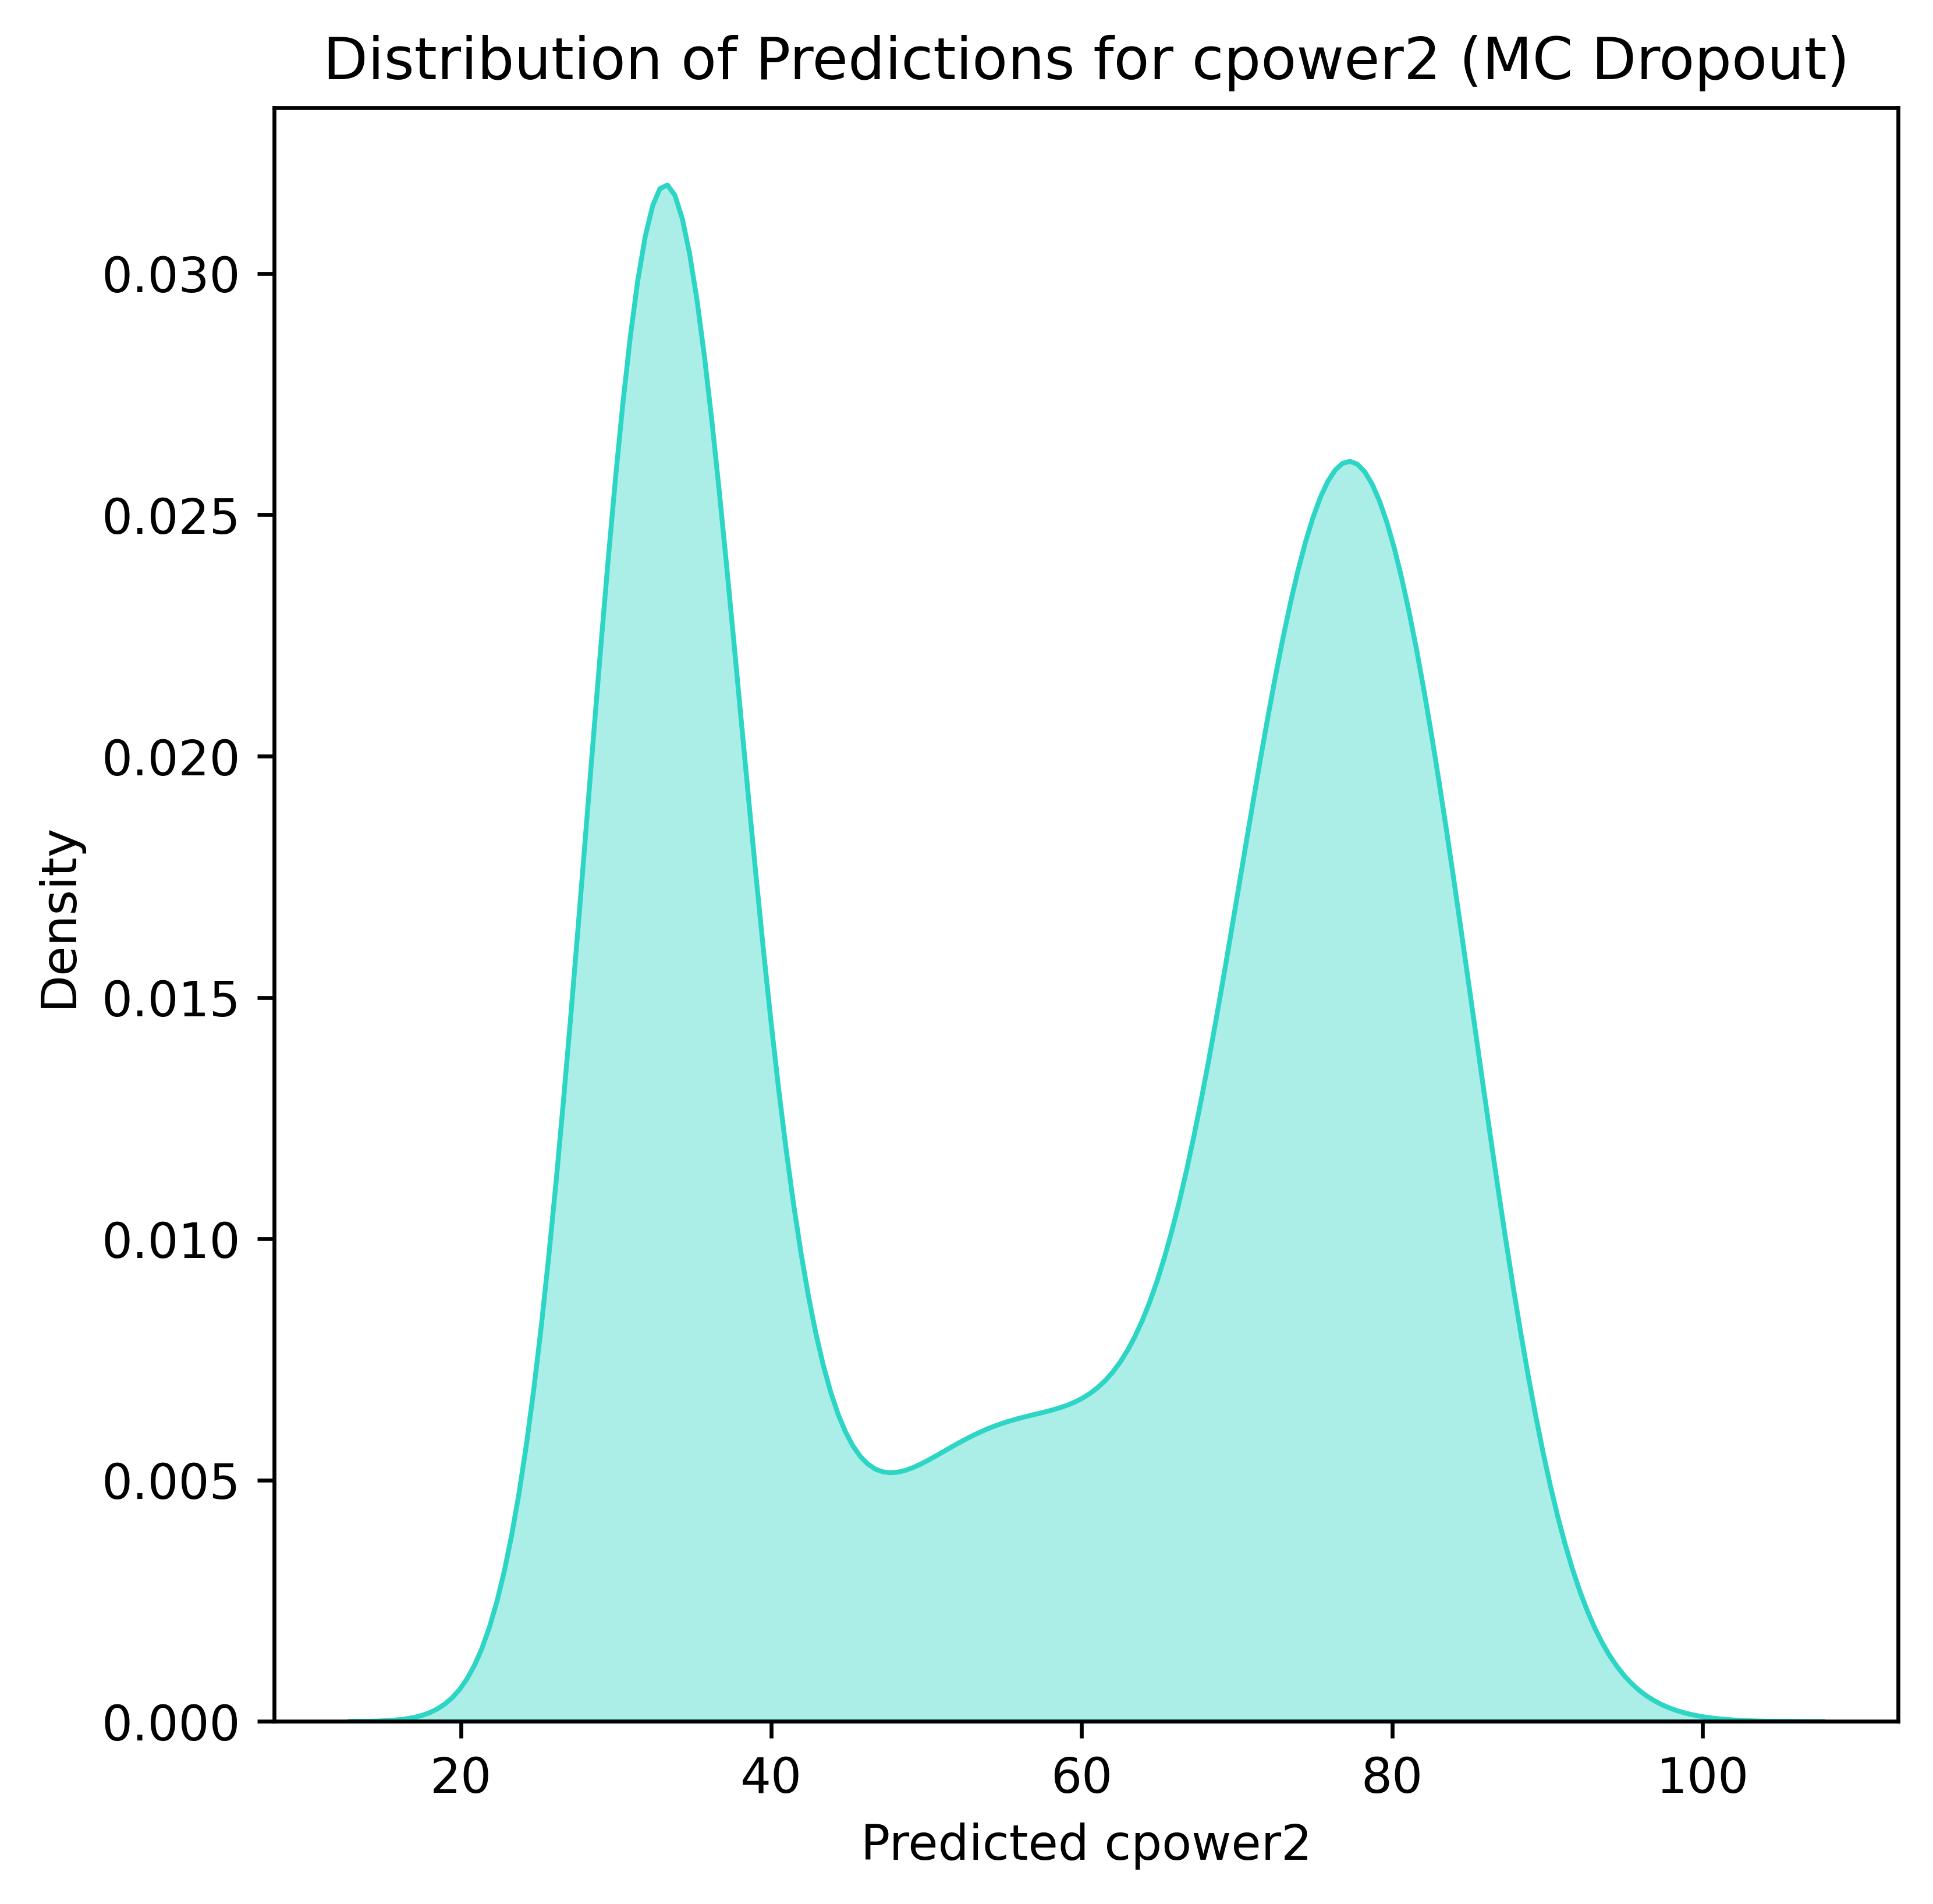

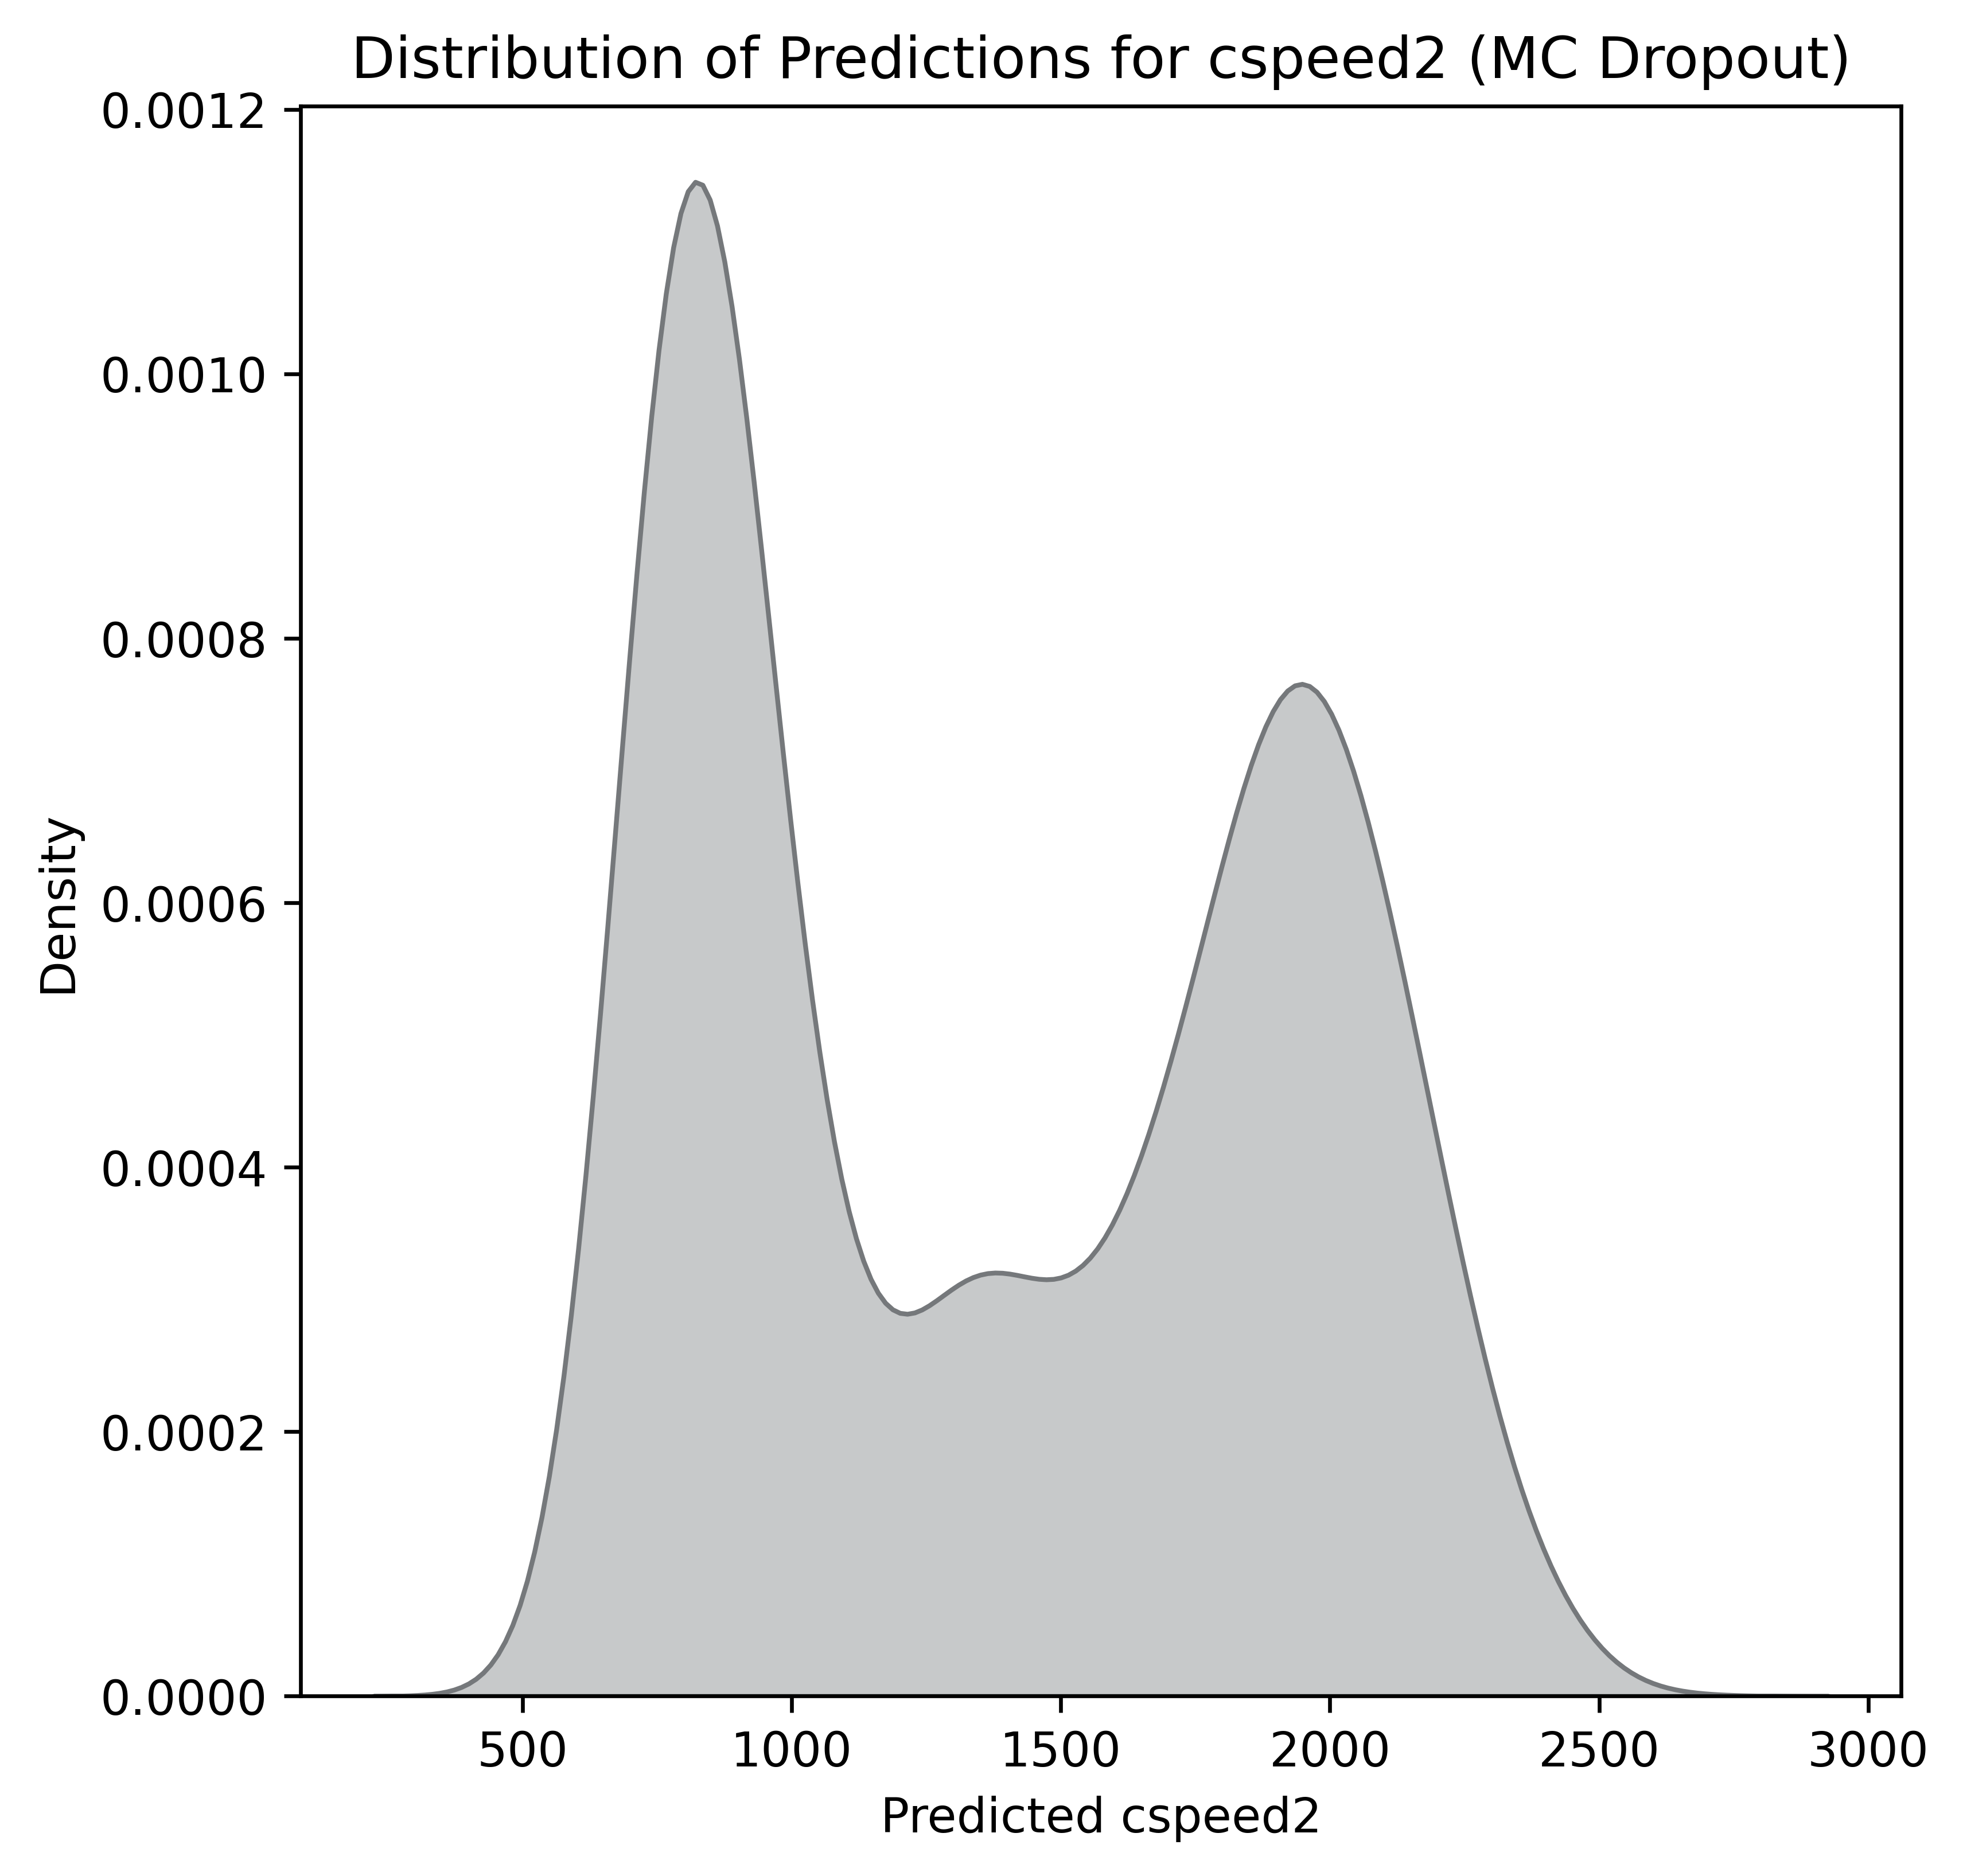

KDE plots saved in 'output_plots/' directory.


In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Ensure the output directory exists
output_folder = "output_plots"
os.makedirs(output_folder, exist_ok=True)

# Load MC Dropout Samples
mc_samples_df = pd.read_csv('mc_dropout_samples.csv')

# Extract parameters
process_params = ['cpower1', 'cspeed1', 'cpower2', 'cspeed2']

# Define color map (same as before to maintain consistency)
parameter_colors = {
    'cpower1': '#861F41',
    'cspeed1': '#E5751F',
    'cpower2': '#2CD5C4',
    'cspeed2': '#75787b'
}

# Generate KDE Plots
for param in process_params:
    plt.figure(figsize=(6, 6), dpi=600)

    # Extract MC samples
    param_samples = mc_samples_df.filter(like=param).values.flatten()

    # KDE Plot
    sns.kdeplot(param_samples, fill=True, color=parameter_colors[param], alpha=0.4)

    # Formatting
    plt.xlabel(f'Predicted {param}')
    plt.ylabel('Density')
    plt.title(f'Distribution of Predictions for {param} (MC Dropout)')

    # Save & Show
    save_path = os.path.join(output_folder, f"{param}_kde.png")
    plt.savefig(save_path, dpi=600, bbox_inches='tight')
    plt.show()

print("KDE plots saved in 'output_plots/' directory.")
